<a href="https://colab.research.google.com/github/devshah21/eye-concentration/blob/main/eye_concentration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install kaggle


[notice] A new release of pip is available: 23.2.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


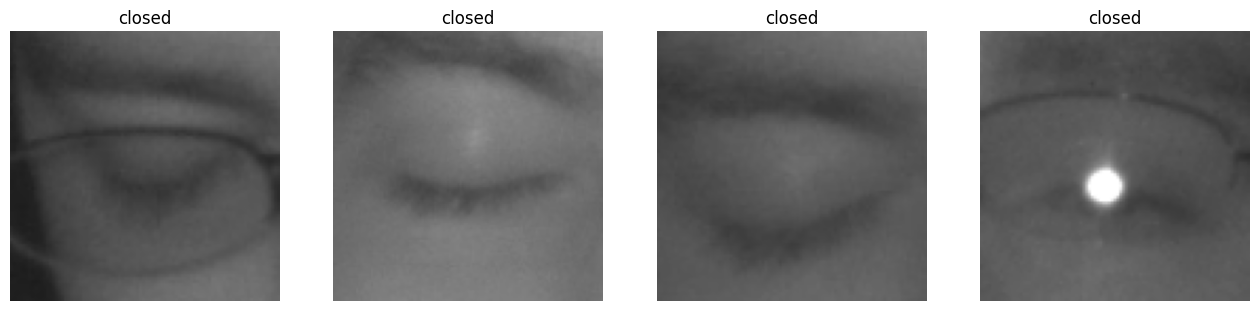

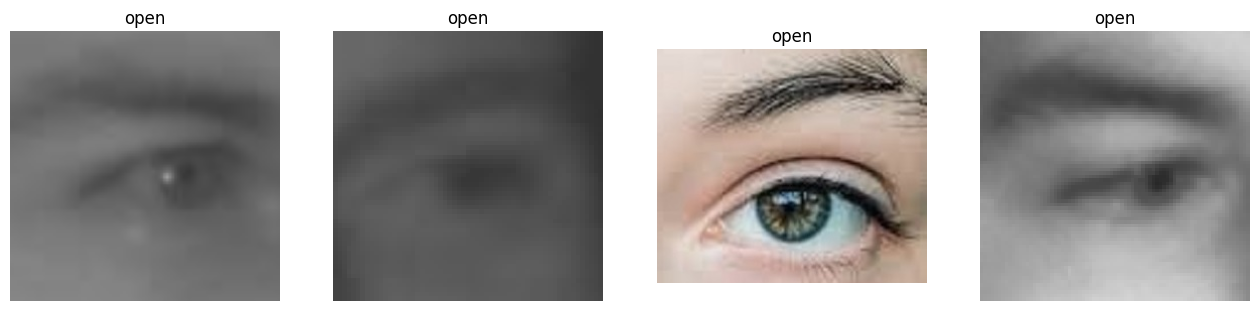

In [16]:
import os
import random
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Paths to the dataset
TRAIN_PATH = "dataset/eye-detection/train"
TEST_PATH = "dataset/eye-detection/test"

# Function to view random images from both classes
def view_random_images(path, class_name):
    plt.figure(figsize=(16, 16))

    for i in range(4):
        plt.subplot(1, 4, i + 1)

        # Corrected the path by adding a forward slash between path and class_name
        random_img = random.choice(os.listdir(path + '/' + class_name))
        img = cv2.imread(path + '/' + class_name + '/' + random_img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.imshow(img)
        plt.title(class_name)
        plt.axis('off')

    plt.show()

# Display random images from both classes
view_random_images(TRAIN_PATH, "closed")
view_random_images(TRAIN_PATH, "open")

<BarContainer object of 6 artists>

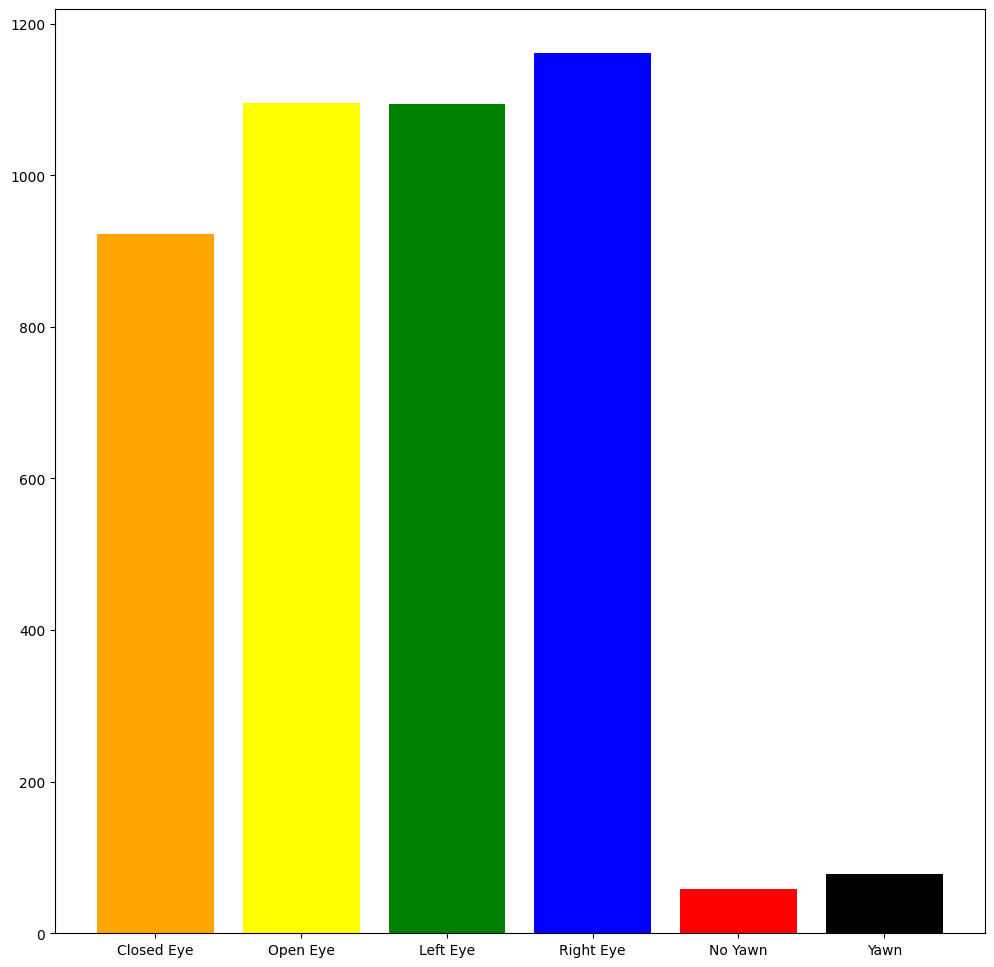

In [9]:
closed_eye = len(os.listdir('/content/eye-detection/test/closed'))
open_eye = len(os.listdir('/content/eye-detection/test/open'))
left_eye = len(os.listdir('/content/eye-direction/test/left'))
right_eye = len(os.listdir('/content/eye-direction/test/right'))
no_yawn = len(os.listdir('/content/yawn-detection/test/no_yawn'))
yawn = len(os.listdir('/content/yawn-detection/test/yawn'))

plt.figure(figsize=(12, 12))

plt.bar(["Closed Eye", "Open Eye", "Left Eye", "Right Eye", 'No Yawn', 'Yawn'],
 [closed_eye, open_eye, left_eye, right_eye, no_yawn, yawn],
        color=['orange', 'yellow', 'green', 'blue', 'red', 'black'])


In [18]:
import torchvision.transforms as transforms

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), shear=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [19]:
DIMS = (128,128)
IMG_SIZE = 128
BATCH_SIZE = 32
SEED = 42

In [20]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

train_dataset = ImageFolder(root=TRAIN_PATH, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = ImageFolder(root=TEST_PATH, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [23]:
print(f"there are {len(train_loader)} training images")
print(f"there are {len(test_loader)} testing images")

there are 274 training images
there are 64 testing images


In [28]:
import torch
import torch.nn as nn
import torch.optim as optim

## model for training
class EyeStateNet(nn.Module):
    def __init__(self):
        super(EyeStateNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((7, 7))  # Adjust output size to 7x7
        self.fc1 = nn.Linear(128 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, 2)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [25]:
model = EyeStateNet()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs
        labels = labels
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        
        if i == 0:  # Print shapes for the first batch
            print(f"Input shape: {inputs.shape}")
            print(f"Output shape: {outputs.shape}")
    
    epoch_loss = running_loss / len(train_dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs
            labels = labels
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f"Validation Accuracy: {accuracy:.2f}%")

print("Training completed!")

In [15]:
data_gen = ImageDataGenerator(rescale=1/255)

In [17]:
TRAIN_DIR = '/content/eye-detection/train/'
TEST_DIR = '/content/eye-detection/test'

In [18]:
train_data = data_gen.flow_from_directory(batch_size=BATCH_SIZE, directory=TRAIN_DIR, shuffle=True,
                                            target_size=DIMS, class_mode='categorical')

test_data = data_gen.flow_from_directory(batch_size=BATCH_SIZE, directory=TEST_DIR, shuffle=True,
                                            target_size=DIMS, class_mode='categorical')

Found 8749 images belonging to 2 classes.
Found 2018 images belonging to 2 classes.


In [4]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input,Conv2D,Dropout, MaxPooling2D,Dense,Activation,BatchNormalization, Flatten
from tensorflow.keras.preprocessing import image
import numpy as np
import tensorflow as tf


In [5]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import PIL
import cv2
import requests
from io import BytesIO
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, array_to_img, img_to_array
from tensorflow.keras import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.backend import clear_session

from tensorflow.keras.applications import InceptionResNetV2,InceptionV3
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.xception import Xception

In [8]:
IMG_SHAPE = (128,128,3)
base_model = InceptionV3(input_shape=IMG_SHAPE, include_top=False, weights='imagenet', classes=70)

In [20]:
base_model.trainable = False

model = Sequential()
model.add(base_model)
model.add(Dropout(0.2))
model.add(GlobalAveragePooling2D())
model.add(Dense(2,activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 dropout_2 (Dropout)         (None, 2, 2, 2048)        0         
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 2)                 4098      
                                                                 
Total params: 21806882 (83.19 MB)
Trainable params: 4098 (16.01 KB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________


In [10]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=2, factor=0.001)
es = EarlyStopping(monitor='val_loss', verbose=2, patience=5, min_delta=0.001)

In [12]:
train_data = '/content/eye-detection/train'

In [21]:
results = model.fit(train_data, validation_data=test_data,
                epochs=10, verbose=1, callbacks=[reduce_lr,es])

Epoch 1/10
274/274 [==============================] - 321s 1s/step - loss: 0.1428 - accuracy: 0.9720 - val_loss: 0.5254 - val_accuracy: 0.9430 - lr: 0.0100
Epoch 2/10
274/274 [==============================] - 311s 1s/step - loss: 0.0710 - accuracy: 0.9879 - val_loss: 0.1599 - val_accuracy: 0.9757 - lr: 0.0100
Epoch 3/10
274/274 [==============================] - 312s 1s/step - loss: 0.0309 - accuracy: 0.9939 - val_loss: 0.1447 - val_accuracy: 0.9812 - lr: 0.0100
Epoch 4/10
274/274 [==============================] - 312s 1s/step - loss: 0.0808 - accuracy: 0.9912 - val_loss: 0.2439 - val_accuracy: 0.9772 - lr: 0.0100
Epoch 5/10
274/274 [==============================] - 311s 1s/step - loss: 0.0319 - accuracy: 0.9946 - val_loss: 0.2903 - val_accuracy: 0.9727 - lr: 0.0100
Epoch 6/10
274/274 [==============================] - ETA: 0s - loss: 0.0165 - accuracy: 0.9969
Epoch 6: ReduceLROnPlateau reducing learning rate to 9.999999776482582e-06.
274/274 [==============================] - 311s 

In [22]:
model.save('model.h5')